# QF600 Asset Pricing
## Linear Factor Models
### Chia Jun Xian Edmund

Risk_Factors.xlsx contains monthly observations of the risk-free rate and the three Fama–French risk factors (expressed as percentages, but without "%"), over the ten-year period from Jan 2004 through Dec 2013.

Using excess returns for the ten industry portfolios, calculate the following performance metrics:

1. Sharpe ratio
2. Sortino ratio (using risk-free rate as target)
3. Treynor ratio (using CAPM β)
4. Jensen's α
5. Three-factor α

where Ri is return on industry portfolio and Rf is risk-free rate.

6. Create a table showing the performance metrics for the ten industry portfolios.

7. Plot your results as a bar chart for each performance metric.

8. Briefly explain the economic significance of each of the three performance ratios (but not α's).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplot, scatter, plot, axis
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
warnings.filterwarnings('ignore')

In [2]:
Industry_Portfolio = \
    pd \
        .read_excel('Industry_Portfolios.xlsx')

Risk_Factors = \
    pd \
        .read_excel('Risk_Factors.xlsx')

In [3]:
#get industry list
industry_list = \
    Industry_Portfolio \
        .columns \
            .to_list()

industry_list.remove('Date')

In [4]:
combined = \
    Industry_Portfolio \
        .merge(
            Risk_Factors,
            how = 'left',
            left_on = 'Date',
            right_on = 'Date'
            )

In [5]:
for industry in industry_list:
    # computing excess return
    combined[industry] = \
        combined[industry] - combined.Rf

## 1. Sharpe Ratio

In [6]:
Sharpe = \
    {
        'Industry' : [],
        'Sharpe Ratio' : [],
    }

for industry in industry_list:

    Sharpe['Industry'].append(industry)

    sharpe_calc = \
        combined[industry].mean() / combined[industry].std()
    
    Sharpe['Sharpe Ratio'].append(sharpe_calc)

Sharpe = \
    pd.DataFrame(Sharpe)

# nb: if information ratio target is rf then is sharpe ratio

## 2. Sortino ratio (using risk-free rate as target)

In [7]:
Sortino = \
    {
        'Industry' : [],
        'Sortino Ratio' : [],
    }

for industry in industry_list:

    industry_downside = combined[[industry]]

    # semi variance: if return - target return < 0 then square
    industry_downside['downside_risk'] = \
        np.where(
            industry_downside[industry] < 0,
            industry_downside[industry] ** 2,
            0
        )        
    
    # mean / sqrt(mean of below benchmark returns)
    sortino_ratio = industry_downside[industry].mean() / np.sqrt(industry_downside.downside_risk.mean())

    Sortino['Industry'].append(industry)

    Sortino['Sortino Ratio'].append(sortino_ratio)

Sortino = \
    pd.DataFrame(Sortino)


## 3. Treynor ratio (using CAPM β)


In [8]:
#create regression dictionary to append
variables = {
    'Industry' : [],
    'α' : [],
    'β' : [],
    'mean_ret' : []
    }

#market model X is excess market returns, Ri - Rf = a + b(rm - rf)
X = \
    combined['Rm-Rf']

X = sm.add_constant(X)

#loop each industry and run regression
for industry in industry_list:
    Y = \
        combined[industry]

    market_model = sm.OLS(Y,X)

    market_result = market_model.fit()

    variables['Industry'].append(industry)

    variables['α'].append(market_result.params[0]) # intercept

    variables['β'].append(market_result.params[1]) # slope

    variables['mean_ret'].append(combined[industry].mean())

variables = \
    pd \
        .DataFrame(variables)

variables['Treynor Ratio'] = \
    variables.mean_ret / variables.β

Treynor_Ratio = \
    variables[['Industry', 'Treynor Ratio']]

## 4. Jensen's α


In [9]:
# take from treynor market model regression intercept
Jensen_α = \
    variables[['Industry', 'α']] \
    .rename(
        columns = {'α' : 'Jensen α'}
    )

## 5. Three-factor α

In [10]:
three_factor = \
    {
        'Industry' : [],
        'three factor α' : []
    }

three_facter_x = \
    combined[
        ['Rm-Rf', 
         'SMB', 
         'HML']
        ]

three_facter_x = \
    sm \
        .add_constant(three_facter_x)

for industry in industry_list:

    three_facter_y = \
        combined[industry]
    
    three_facter_model = \
        sm.OLS(three_facter_y, three_facter_x)
    
    three_facter_result = three_facter_model.fit()
    
    three_facter_α = \
        three_facter_result.params[0]
    
    three_factor['Industry'].append(industry)

    three_factor['three factor α'].append(three_facter_α)


three_factor = \
    pd \
        .DataFrame(three_factor)

In [16]:
# gives beta for each factor
three_facter_result.params

const   -0.404412
Rm-Rf    1.123473
SMB     -0.061676
HML      0.547325
dtype: float64

## 6. Create a table showing the performance metrics for the ten industry portfolios.


In [11]:
performance_metrics = \
        Sharpe \
            .merge(
                Treynor_Ratio,
                how = 'inner',
                left_on = 'Industry',
                right_on = 'Industry'
            ) \
            .merge(
                Sortino,
                how = 'inner',
                left_on = 'Industry',
                right_on = 'Industry'
            ) \
            .merge(
                Jensen_α,
                how = 'inner',
                left_on = 'Industry',
                right_on = 'Industry'
            ) \
            .merge(
                three_factor,
                how = 'inner',
                left_on = 'Industry',
                right_on = 'Industry'
            )

performance_metrics

,Industry,Sharpe Ratio,Treynor Ratio,Sortino Ratio,Jensen α,three factor α
0,NoDur,0.231099,1.186372,0.350804,0.369717,0.386704
1,Durbl,0.072356,0.367463,0.111967,-0.417903,-0.474342
2,Manuf,0.166616,0.758251,0.241260,0.160494,0.153285
3,Enrgy,0.181708,1.143330,0.273612,0.504485,0.523007
4,HiTec,0.118552,0.564295,0.170620,-0.064024,-0.065979
5,Telcm,0.169064,0.836363,0.244940,0.194348,0.200724
6,Shops,0.191753,0.951258,0.293032,0.274093,0.255941
7,Hlth,0.172529,0.971435,0.270294,0.236968,0.257472
8,Utils,0.210948,1.452334,0.290044,0.446523,0.474411
9,Other,0.064693,0.299781,0.087351,-0.387508,-0.404412


## 7. Plot your results as a bar chart for each performance metric.

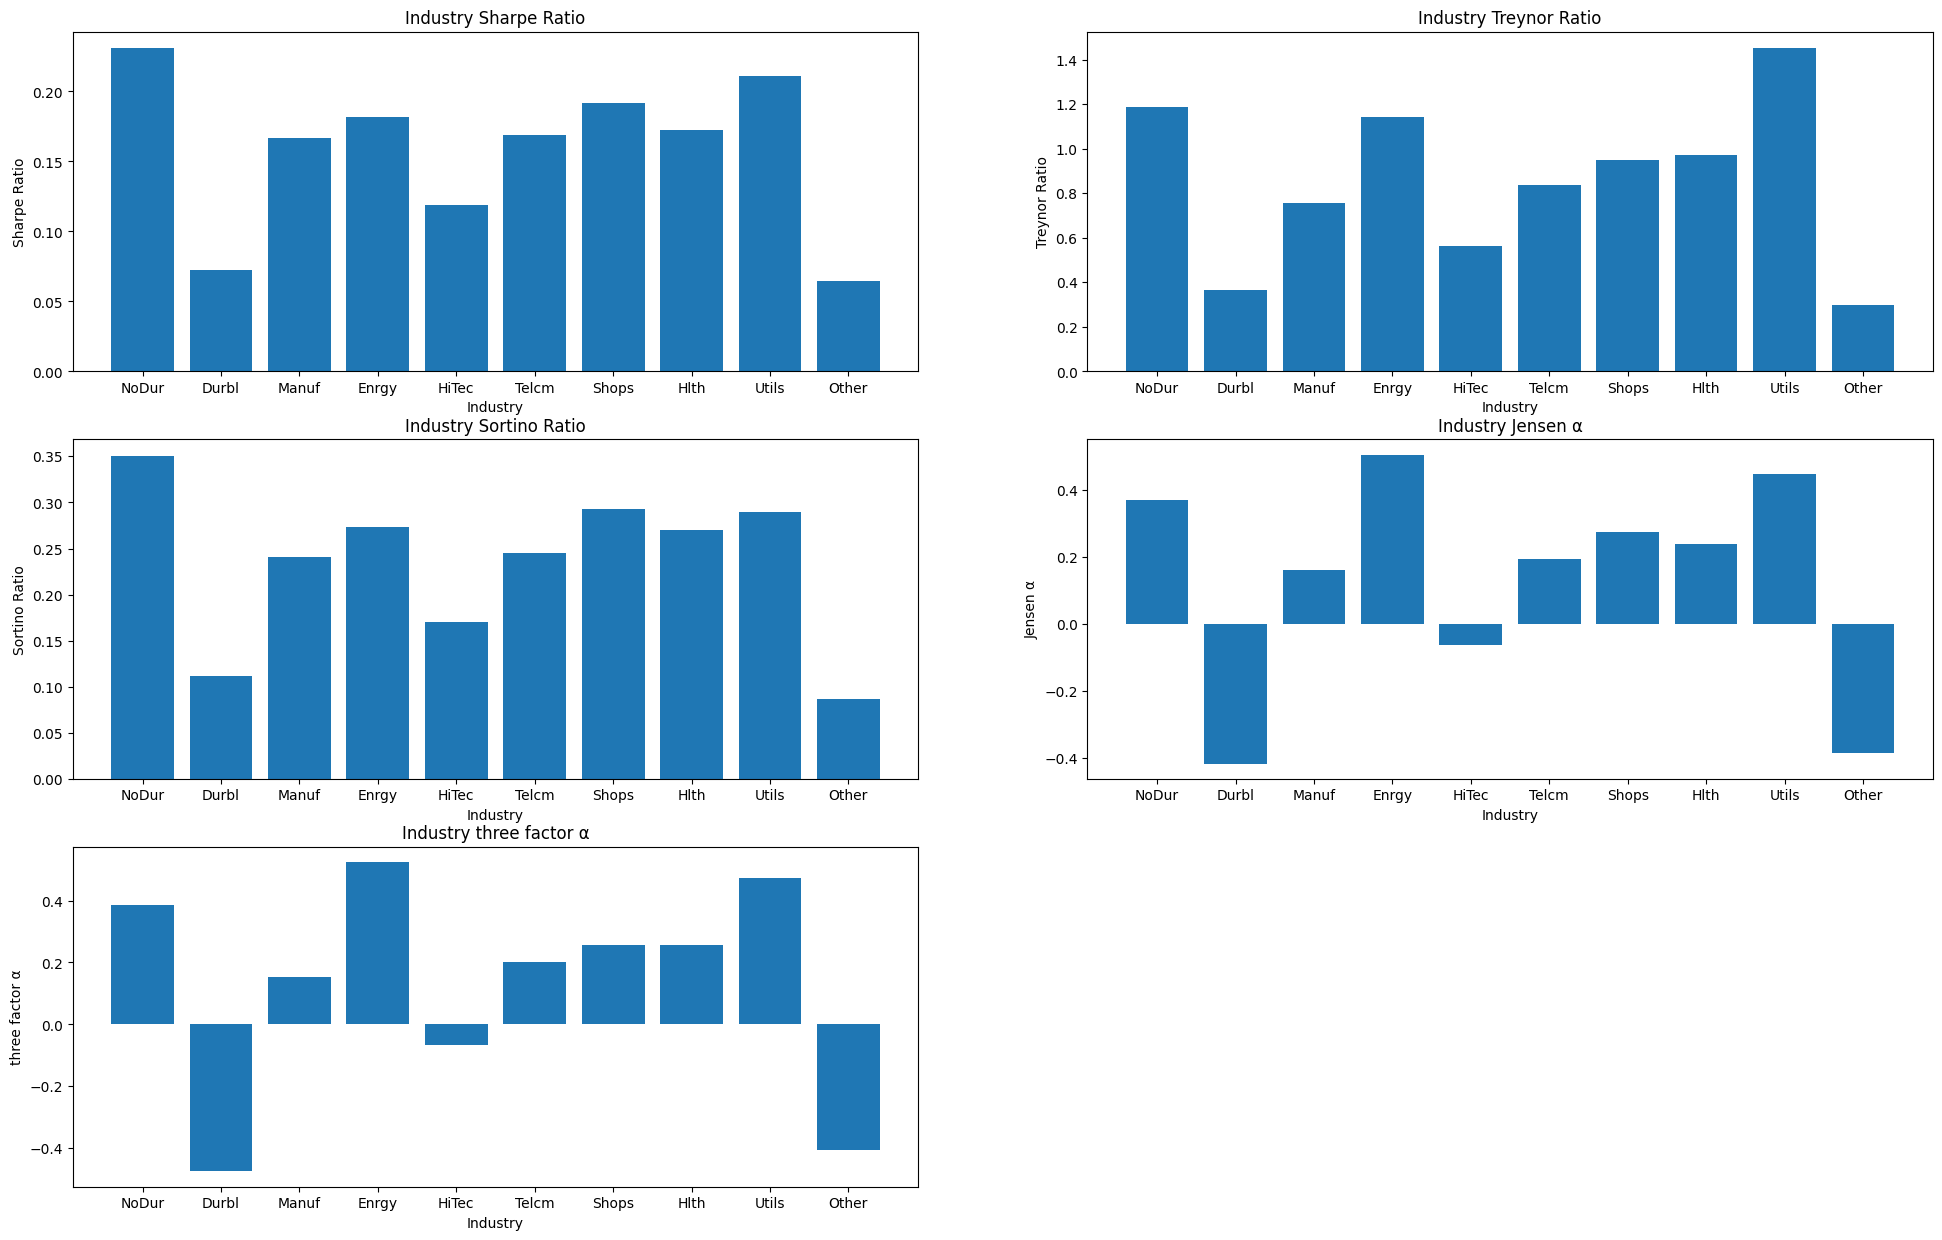

In [12]:
plt.figure(figsize=(24, 15))

metrics_list = performance_metrics.columns.to_list()
metrics_list.remove('Industry')

for metric in range(len(metrics_list)):

    subplot(3, 2, metric + 1)

    plt \
        .bar(performance_metrics['Industry'], 
            performance_metrics[metrics_list[metric]]
            )

    plt \
        .xlabel('Industry')

    plt \
        .ylabel(metrics_list[metric])

    plt \
        .title('Industry ' + metrics_list[metric])


## 8. Briefly explain the economic significance of each of the three performance ratios (but not α's).

Sharpe Ratio: Measures risk premium per unit of standard deviation. The standard deviation captures the total risk (systematic and idiosyncratic risk). It is useful when comparing the performance of diversified portfolio where the idiosyncratic risk is minimized but not between individual investment and diversified portfolios. Assumes normal distribution so cannot distinguish between asymmetric return distributions with same variance but different skewness\
\
Treynor Ratio: Measures risk premium per unit of market risk. The denominator, beta, captures the systematic risk, ignoring idiosyncratic risk. Hence, it can be used to compare the performance of individual investment to diversified portfolio. \
\
Sortino Ratio: Measures the expected deviation from a benchmarked return per unit of below target semi deviation. Below target semi deviation only considers risk that realised return on investment falls below the target return. Sortino Ratio is able to distinguish between asymmetric return distributions with same variance but different skewness. Returns with the same variance but different skewness would have the same Sharpe Ratio but different sortino ratio.